In [1]:
# the code to make plots for Figure 2 (wt curves, prob plots, pop. level )

import torch
import sys
import os
import io
from os.path import exists
import numpy as np
from os.path import exists
import pickle
import ipywidgets as widgets 
import json

import numpy as np
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
from scipy.stats import ranksums, wilcoxon
from dynamics.utils import utils
from dynamics.vis import dynamics as dyplot
from scipy.linalg import schur
from scipy.special import softmax
from mpl_toolkits.mplot3d import Axes3D
from scipy.io import savemat
from torch import nn


from dynamics.process.rnn import wt_kindergarten, wt_nets, wt_costs 
from dynamics.process.rnn import wt_reinforce_cont_new, wt_pred, parse, linearize, parse_state
from dynamics.vis import wt_vis
from dynamics.analysis import wt_analysis as wta
from dynamics.utils.utils import CPU_Unpickler,parse_configs, displ, memcheck, opsbase,mwa
from dynamics.utils import utils
from dynamics.analysis import state_analysis as sta


from sklearn.cross_decomposition import CCA
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression, LinearRegression
from scipy import interpolate
import statsmodels.api as sm

%load_ext autoreload
%autoreload 2
#%matplotlib notebook
#%matplotlib widget 
#out = widgets.Output(layout = widgets.Layout(height='300px'))

In [18]:
#pull beh data from a beh.json file. used for nok_nocl data for the wtr dist
def retrieve_behdat(fname_behdat, fname):
    """ helper code to lookup the dat in the behavioral data.
    if fname_behda is a list, just search it (for faster lookup)
    if a filename, load the file."""
    
    fname_base = fname.split('/')[-1]
    dat = None
    
    if type(fname_behdat) is list:  #easier to recylce
        datlist = fname_behdat
    else:
        #datlist = pickle.load(open(fname_behdat,'rb'))
        datlist = json.load(open(fname_behdat,'r'))
 
    for j in datlist:
        if j['name'] == fname_base:
            dat = j
            break
            
    return dat

In [10]:
# directories where data are. TODO: move to local

#params to choose RNN
num = 7  # RNN number
s_idx = 0  #the curriculum type full_redo(0), nok_cl(1), nok_nocl (2), etc.
tphase = 5 #simple(0), int(1), pred(2), nocatch(3), catch(4), block(5)
idx = 10 #index within that phase of learning. remember that int and pred can be variable amounts


#num = 7  # RNN number
#s_idx = 6  #the curriculum type full_redo(0), nok_cl(1), nok_nocl (2), etc.
#tphase = 5 #simple(0), int(1), pred(2), nocatch(3), catch(4), block(5)
#idx = 10 #index within that phase of learning. remember that int and pred can be variable amounts


#the full taxonomy of names
#subdirlist = ['full_cl_redo/', 'nok_cl/','nok_nocl/','pkind_mem/', 'pkind_pred/', 'pkind_int/', 'full_cl/']
#dbase = '/scratch/dh148/dynamics/results/rnn/ac/20230206_clstudy/'

subdirlist = ['full_cl/', 'nok_cl/','nok_nocl/','pkind_mem/','pkind_count/', 'pkind_int/', 'pkind_pred/']
dbase = '/scratch/dh148/dynamics/results/rnn/ac/20231003/'
datadir_dat = lambda s_idx: dbase+subdirlist[s_idx]


savedir = dbase+subdirlist[s_idx]+'dynamics/KEmin_constrained/'  #for previously sim. data, 1k trials
savedir_stats = dbase+subdirlist[s_idx]+str(num)+'/'  #for stats based on simulation of 10k trials

fgen = lambda num,idx, base, sess, s_idx : datadir_dat(s_idx)+str(num)+'/'+base + str(num)+'_'+sess+'_'+str(idx)

fname_funs = [lambda num,idx, s_idx: datadir_dat(s_idx)+str(num)+'/'+'rnn_kindergarten_' + str(num)+'_simple',
          lambda num,idx, s_idx: datadir_dat(s_idx)+str(num)+'/'+'rnn_kindergarten_' + str(num)+'_int_0_'+str(idx),
          lambda num,idx, s_idx: datadir_dat(s_idx)+str(num)+'/'+'rnn_pred_' + str(num)+'_pred_'+str(idx),
          lambda num,idx, s_idx: fgen(num, idx, 'rnn_curric_', 'nocatch', s_idx),
          lambda num,idx, s_idx: fgen(num, idx, 'rnn_curric_', 'catch', s_idx),
          lambda num,idx, s_idx: fgen(num, idx, 'rnn_curric_', 'block', s_idx),
          lambda num,idx, s_idx: fgen(num, idx, 'rnn_curric_', 'block', s_idx)+'_freeze'
         ]

# load network and previous data
modelname = fname_funs[tphase](num, idx, s_idx)+'.model'

basename = modelname.split('/')[-1].split('.')[0]
savename = modelname.split('.')[0]+ '_1k.json'
statsname = savedir_stats + basename +'.stats'
configname = 'Fig2.cfg'
ops, _ = utils.parse_configs(configname)

fname_behdat_fun_1k = lambda num,s_idx: datadir_dat(s_idx) + 'rnn_'+str(num)+'_allbeh_1k.json'

uniqueops: adam_fname not defined in config. using default


In [3]:
statsname
modelname = fname_funs[tphase](num, idx, s_idx)+'.model'
modelname

'/scratch/dh148/dynamics/results/rnn/ac/20231003/full_cl/7/rnn_curric_7_block_10.model'

In [4]:
resim = False
ops['ns'] = 1000 #for quick data
#ops['ns'] = 10000 # for quality data

In [5]:
if resim: #note, should do 10k trials to get good w.t. curves. will take like an hour. 
    print('simulating')
    dat = wt_reinforce_cont_new.session_torch_cont(ops, net, optimizer, costfun, device)
    wt_dict, linreg, numdict, rho_all, ops = wta.parsesimulation(dat, ops)
    wtlist, reg_hist, reg_block = wta.modelagnostic_test(dat, dt=ops['dt'])
    adapt_20_ratio = wt_dict['wt_high'][2] / wt_dict['wt_low'][2]
    b = linreg['b_mixed']
    nums = numdict
else:
    print('loading prev. simulated')
    with open(savename,'r') as f:
        dat = json.load(f)
        dat = parse.json2dat(dat)
    dat_stat = pickle.load(open(statsname,'rb'))
    wt_dict = dat_stat[0]
    pval,slope,adapt_20_ratio,nums, wtrange,b, wtdat, reg_histdat, reg_blockdat = parse.load_dat4stats(statsname)

print('done')
    

loading prev. simulated
done


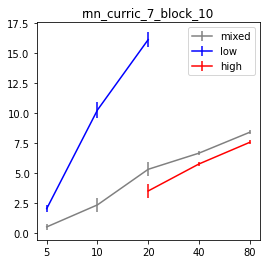

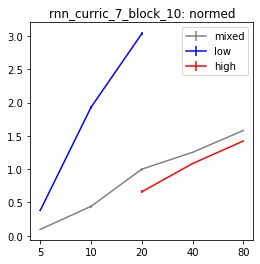

[{'win': 0.5563, 'optout': 0.4364, 'vio': 0.0073}, -4.034194304562942]
0.21774296970885684


In [6]:
# wait time curve (Fig. 2 and supp fig 4)
fig, fig2 = wt_vis.plotblocks(wt_dict, name=basename)
print([nums,b])
print(adapt_20_ratio)

In [56]:
savedir_tmp = '/scratch/dh148/dynamics/results/rnn/ac/20231003/full_cl/figs/'
fig.savefig(savedir_tmp+'rnn_'+str(num)+'.pdf')

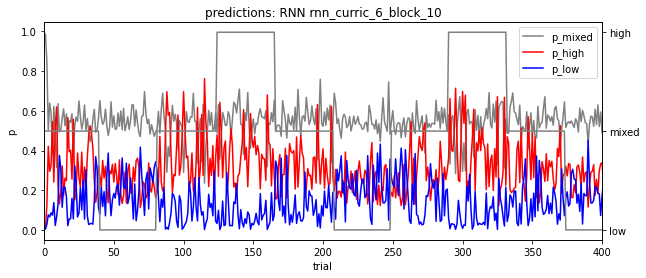

In [57]:
#prediction plots

#preprocess
sflat, inp, tdict = parse.get_trialtimes(dat)
warpstate = False
preds = dat['preds']
rew = dat['rewvols']
inp = np.array([np.squeeze(np.squeeze(k[0].detach().numpy())) for k in inp])
offers = inp[inp[:,0]>0,0]

#sometimes there is a fencepost error. maybe a trial not finishing?
nx = min([len(tdict['start']), len(offers)])

preds_ontrial = np.zeros((nx,3))
predflat = []
for k in preds:
    predflat.extend(k)


for k in range(nx):
    #idx = tdict['start'][trial_idx]-1 # for trial predition
    idx = tdict['start'][k] # for block prediction
    preds_ontrial[k,:] = softmax(predflat[idx])


#the plot itself
fig = plt.figure(figsize=(10,4))
Vlab = ['p_mixed','p_high','p_low']

block_redo = np.array(dat['blocks'])
block_redo[block_redo==1] = 10
block_redo[block_redo==2] = -10
block_redo[block_redo==10] = 1
block_redo[block_redo==-10] = -1

colors = ['gray','red','blue', 'brown','brown']
for k in range(3):
    #plt.plot(mwa(preds_ontrial[:,k],10),label=Vlab[k], color = colors[k])
    plt.plot(preds_ontrial[:,k],label=Vlab[k], color = colors[k])

plt.xlabel('trial')
plt.ylabel('p')
ax = plt.gca()
ax2=plt.gca().twinx()
ax2.plot(block_redo,'gray')
ax2.set_yticks([0,1,-1],labels=['mixed','high','low'])
plt.title('predictions: RNN ' + basename)
plt.xlim([0,400])
ax.legend()
plt.savefig(savedir_tmp+'rnn_'+str(num)+'_pred.pdf')
plt.show()

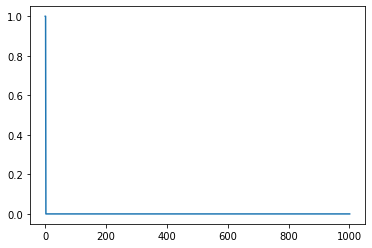

In [62]:

plt.plot(preds_ontrial[:,1] > preds_ontrial[:,2], label='high wins')


In [24]:
#population level: wait time ratio
#just visualize them all at once. also get the adaptation ratios

ops = utils.opsbase()
ops['useblock'] = True

#decide here what you want to look at
ratios_all = []
idxmax = [10,60,40]
modelname = fname_funs[tphase](num, idx, s_idx)+'.model'

for k in range(3):

    numuse = []
    if k < 2:
        nmax = 51
    else:
        nmax = 21
    
    for j in range(1,nmax):
        if k == 0:
            modelname_j = fname_funs[5](j, idxmax[k], k)+'.model'
        else:
            modelname_j = fname_funs[6](j, idxmax[k], k)+'.model'
        basename_j = modelname_j.split('/')[-1].split('.')[0]
        savedir_stats = dbase+subdirlist[k]+str(j)+'/'
        statsname_j = savedir_stats + basename_j +'.stats'
        #print(statsname_j)
        if k < 2:
            if os.path.exists(statsname_j):
                numuse.append(j)
        else:  # nok_nocl
            fname_behdat = fname_behdat_fun_1k(j,k)
            fname = fname_funs[5](j, idxmax[k], k).split('/')[-1]+'_1k'+'.json'

            #load data    
            try:
                dat_stat = retrieve_behdat(fname_behdat,fname)
                if dat_stat is not None:
                    numuse.append(j)
            except:   
                print('Json error. skipping')
                dat_stat = None

    nuse = len(numuse)
    print(nuse)
    ratios = []

    for j in numuse:
        
        if k < 2:
            if k == 0:
                modelname_j = fname_funs[5](j, idxmax[k], k)+'.model'
            elif k ==1:
                modelname_j = fname_funs[6](j, idxmax[k], k)+'.model'       
            basename_j = modelname_j.split('/')[-1].split('.')[0]
            savedir_stats = dbase+subdirlist[k]+str(j)+'/'
            statsname_j = savedir_stats + basename_j +'.stats'     
            pval,slope,adapt_20_ratio,nums, wtrange,b, wtdat, reg_histdat, reg_blockdat = parse.load_dat4stats(statsname_j)
            ratios.append(adapt_20_ratio)
        else:
            fname_behdat = fname_behdat_fun_1k(j,k)
            fname = fname_funs[5](j, idxmax[k], k).split('/')[-1]+'_1k'+'.json'
            dat_stat = retrieve_behdat(fname_behdat,fname)
            wt_dict, linreg, numdict, rho_all, ops = wta.parsesimulation(dat_stat, ops)
            adapt_20_ratio = wt_dict['wt_high'][2] / wt_dict['wt_low'][2]
            ratios.append(adapt_20_ratio)
            

        
    ratios_all.append(ratios)
    
ratios_good = ratios_all[0]  # full_cl
ratios_bad = ratios_all[1]  #nok_cl
ratios_bad2 = ratios_all[2]  #nok_nocl
ratios_bads = [ratios_bad,ratios_bad2]
ratios_both = [ratios_good, ratios_bad, ratios_bad2]
ratios_flat = [item for sublist in ratios_both for item in sublist]  # all RNNs
ratios_flat_both = [item for sublist in ratios_bads for item in sublist]  # only the bad curricula


49
46
18
high vs. low comparison: not enough data for ranksum
high vs. low comparison: not enough data for sign rank
high vs. low comparison: not enough data for ranksum
high vs. low comparison: not enough data for sign rank
high vs. low comparison: not enough data for ranksum
high vs. low comparison: not enough data for sign rank
high vs. low comparison: not enough data for ranksum
high vs. low comparison: not enough data for sign rank
high vs. low comparison: not enough data for ranksum
high vs. low comparison: not enough data for sign rank
high vs. low comparison: not enough data for ranksum
high vs. low comparison: not enough data for sign rank
high vs. low comparison: not enough data for ranksum
high vs. low comparison: not enough data for sign rank
high vs. low comparison: not enough data for ranksum
high vs. low comparison: not enough data for sign rank
high vs. low comparison: not enough data for ranksum
high vs. low comparison: not enough data for sign rank
high vs. low compar

In [37]:
49+46+18

113

In [14]:
fname = '/scratch/dh148/dynamics/results/rnn/ac/20231003/nok_nocl/rnn_1_allbeh_1k.json'
with open(fname,'r') as f:
    test = json.load(f)

In [33]:
print('sign rank test: kindergarten CL')
print(wilcoxon(np.array(ratios_good)))
print('sign rank test: all curriculua')
print(wilcoxon(np.array(ratios_flat)))


print(np.nanmean(ratios_good))
print(np.nanmean(ratios_flat))


sign rank test: kindergarten CL
WilcoxonResult(statistic=0.0, pvalue=1.1100954635085601e-09)
sign rank test: all curriculua
WilcoxonResult(statistic=0.0, pvalue=2.803208638992355e-20)
0.7643163528180036
0.929273078609786


[0.         0.10416667 0.20833333 0.3125     0.41666667 0.52083333
 0.625      0.72916667 0.83333333 0.9375     1.04166667 1.14583333
 1.25       1.35416667 1.45833333 1.5625     1.66666667 1.77083333
 1.875      1.97916667 2.08333333 2.1875     2.29166667 2.39583333
 2.5       ]
1.05214799624668
0.9981681984988823


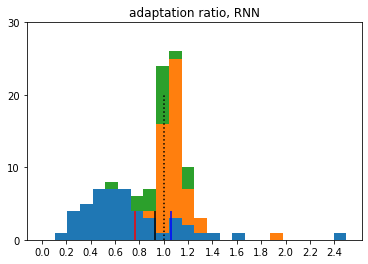

In [38]:
# adaptation ratio histogram

savedir = '/scratch/dh148/dynamics/results/rnn/ac/20231003/figs/'
fig = plt.figure()
bins = np.linspace(0,2.5,25)
print(bins)

plt.hist([ratios_good, ratios_bad, ratios_bad2], bins, alpha = 1, stacked=True)
plt.vlines(np.nanmean(ratios_good),0,4,'r')
plt.vlines(np.nanmean(ratios_flat_both),0,4,'b')
plt.vlines(np.nanmean(ratios_flat),0,4,'k')

print(np.nanmedian(ratios_flat_both))
print(np.nanmedian(ratios_flat))

plt.ylim(0,30)
plt.yticks([0,10,20,30])
plt.xticks([0,0.2,0.4,0.6,0.8,1.0,1.2,1.4,1.6,1.8,2.0,2.2,2.4])

plt.vlines(1.0,0,20,'k',linestyle='dotted')

plt.title('adaptation ratio, RNN')

fig.savefig(savedir+'wtratio_dist.pdf')

plt.show()

#plot the statistic

In [35]:
savedir

'/scratch/dh148/dynamics/results/rnn/ac/20231003/figs/'

In [11]:
def plotblocks_subfig(wt_dict, fig, ax, idx1,idx2, name='title'):
    """
    plots sensitivity to reward, by blocks, in a subfigure
    :param wt_dict: wait-time dicitionary from parsesimulation()
    :param idx: id for output figure
    :param name: plot title
    :return:
    """
    Vvec = np.array([5, 10, 20, 40, 80])

    # plt.errorbar(np.log2(Vvec),wt_dict['wt'],wt_dict['wt_sem'],label='all')
    ax[idx1, idx2].errorbar(np.log2(Vvec), wt_dict['wt_mixed'], wt_dict['wt_mixed_sem'], label='mixed', color='gray')
    ax[idx1, idx2].errorbar(np.log2(Vvec), wt_dict['wt_low'], wt_dict['wt_low_sem'], label='low', color='blue')
    ax[idx1, idx2].errorbar(np.log2(Vvec), wt_dict['wt_high'], wt_dict['wt_high_sem'], label='high', color='red')
    ax[idx1, idx2].set_xticks(np.log2(Vvec))
    ax[idx1, idx2].set_xticklabels(Vvec)
    #ax[idx1, idx2].legend()
    ax[idx1, idx2].set_title(name)
    if 'p_signrank' in wt_dict:
        text2plot = 'sign-rank p: {:.2e} \n ranksum p: {:.2e}'.format(wt_dict['p_signrank'], wt_dict['p_ranksum'])
        ax[idx1,idx2].annotate(text2plot, (0.7, 0.7), xytext=(0.7, 0.7), textcoords='axes fraction')

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50]
50


<Figure size 432x288 with 0 Axes>

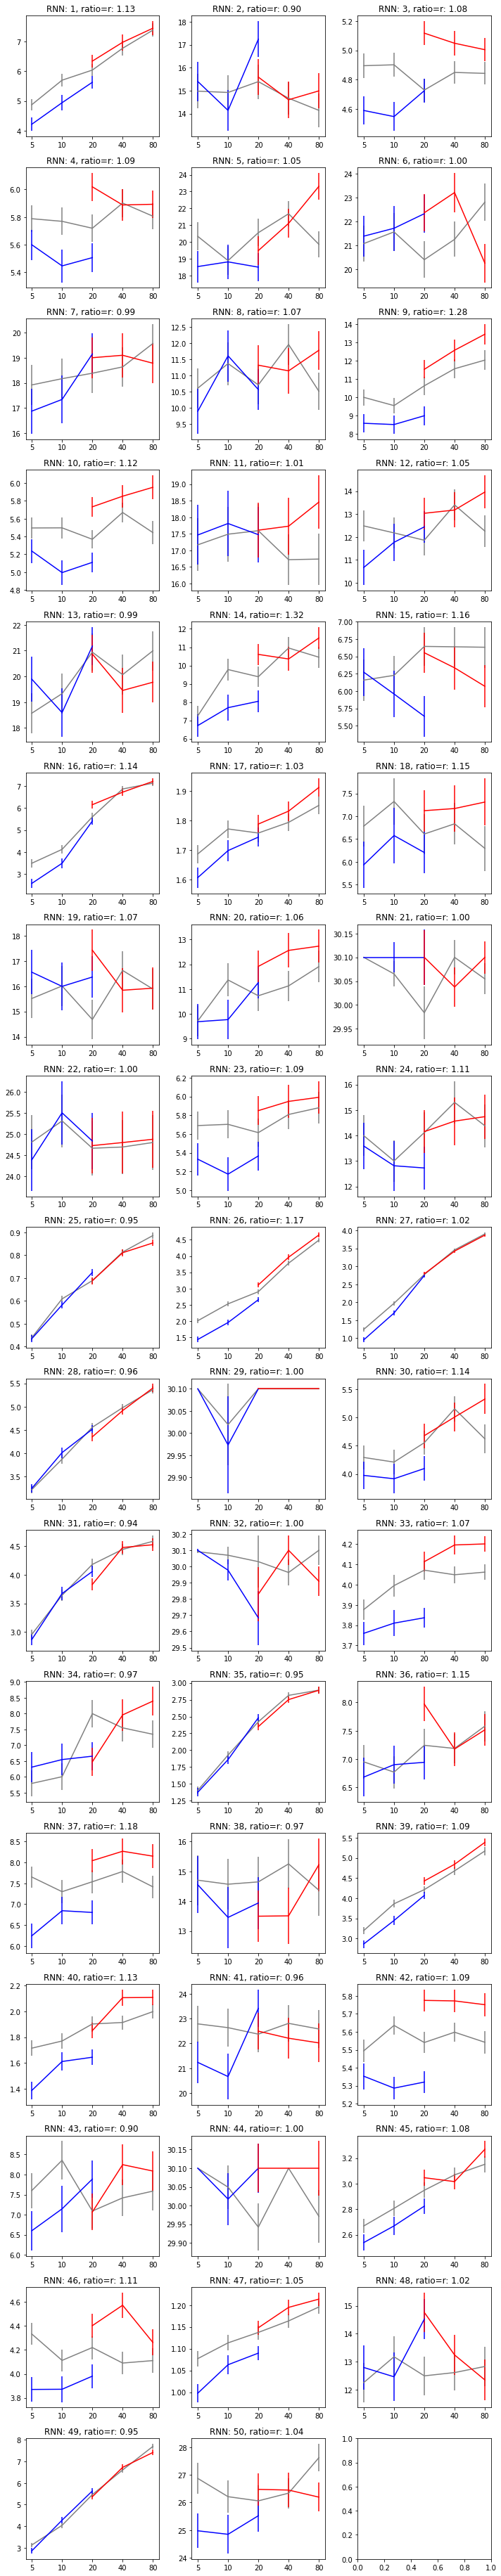

In [12]:
#just visualize them all at once. also get the adaptation ratios

#decide here what you want to look at
idx = 10  # plce in CL stage
t_idx = 5  # CL stage
s_idx = 1 #CL type
#fname_fun_j = lambda j: fname_funs[t_idx](j,idx, s_idx)+'.stats2'
fname_fun_j = lambda j: fname_funs[t_idx](j,idx, s_idx)+'.stats'

fig = plt.figure()
numuse = []
for j in range(1,51):
    fname_stats = fname_fun_j(j)
    #print(fname_stats)

    if os.path.exists(fname_stats):
        numuse.append(j)
print(numuse)
        
nuse = len(numuse)
print(nuse)
nrow = int(np.ceil(nuse/3))
fig, ax = plt.subplots(nrow,3,figsize = (10,nrow*3))

savedir = dbase +subdirlist[s_idx]+'/figs/'

ratios = []

ind = 0
for j in numuse:
    num = j
    fname_stats = fname_fun_j(j)
    #print(fname_stats)
    dat_stat = pickle.load(open(fname_stats,'rb'))
    pval,slope,adapt_20_ratio,nums, wtrange,b, wtdat, reg_histdat, reg_blockdat = parse.load_dat4stats(fname_stats)

    ratio = 'r: {:.2f} '.format(adapt_20_ratio)
    ratios.append(adapt_20_ratio)
    lab = 'RNN: '+str(j)+', ratio=' + ratio
    plotblocks_subfig(dat_stat[0], fig, ax, int(ind/3),ind % 3, name=lab)
    ind +=1


plt.tight_layout()
#fig.savefig(savedir+'allrnn_wt_idx60.pdf')
fig.savefig(savedir+'allrnn_wt_sidx_'+str(s_idx)+'.pdf')
plt.show()

In [13]:
savedir

'/scratch/dh148/dynamics/results/rnn/ac/20231003/nok_cl//figs/'